Ku04AMP01 protein and Phosphatedylglycerol Complex
======================


## ``Gromacs_py`` simulation

Here is an example of a short simulation of the Ku04Amp01 (`kuamp01`) peptide ('protein') in complex with Phosphatedylglycerol (`pgl`) ligand using AMBER force-field model.

Need to do this to properly docked system. The PDB file of ligand must be generated from the canonical SMILES by rdkit. This can be done locally using:

Finally, nine successive steps are used:

1. Load the protein in its best -docked state. 
   
2. In-complex creation of Protein Topology using ``GmxSys.add_top()``, followed by boxing and solvation/neutralization.
   
3. Boxing of complex.
   
4. Ideally, Ligand topology creation using `prepare_top()` which uses `acpype` to build ligand topology. This did not work, so must do this manually using `acpype` externally
   
5. Solvate complex and add ions.

6. Minimisation of the structure using ``GmxSys.em_2_steps()``.

7. Equilibration of the system using ``GmxSys.em_equi_three_step_iter_error()``.

8. Production run using ``GmxSys.production()``.
   
9.  Post-processing using `GmxSys.convert_trj().`

### Import

In [1]:
import sys
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## To use `gromacs_py` in a project

In [2]:
from gromacs_py import gmx

## Simulation setup

- Define a few variables for you simulation, like:
  
    1. simulation output folders
    2. ionic concentration
    3. number of minimisation steps
    4. equilibration and production time

### Regarding equilibriation time:
The following variables define the sim times (relative units) for each stage of the three-stage equilibriation process. Check notes below for details:

1. `HA_time`
2. `CA_time`
3. `CA_LOW_time` 


In [3]:
DATA_OUT = 'ku04amp01_pgl_complex'

# System Setup
vsite='none'
sys_top_folder = os.path.join(DATA_OUT, 'sys_top')
#ignore_hydrogen = {'ignh': None}

# Energy Minimisation
em_folder = os.path.join(DATA_OUT, 'em')
em_sys_folder = os.path.join(DATA_OUT, 'sys_em')
em_step_number = 10000
emtol = 10.0  	# Stop minimization when the maximum force < 10 J/mol
emstep  = 0.01      # Energy step size


# Equillibration
equi_folder = os.path.join(DATA_OUT, 'sys_equi')
HA_time = 0.5
CA_time = 1.0
CA_LOW_time = 4.0

dt_HA = 0.001
dt = 0.002

HA_step = 1000 * HA_time / dt_HA
CA_step = 1000 * CA_time / dt
CA_LOW_step = 1000 * CA_LOW_time / dt

# Production
os.makedirs(DATA_OUT, exist_ok = True)
prod_folder = os.path.join(DATA_OUT, 'sys_prod')
prod_time = 50.0

prod_step = 1000 * prod_time / dt

## Create the `GmxSys` object

Load protein information only from docked PDB file on disk

In [5]:
%%script true

pdb_file = "pdbs/protein.pdb"
sys_name = "ku04amp01_pgl_complex"
complex_sys = gmx.GmxSys(name=sys_name, coor_file=pdb_file)

## Create topology and stuff

1. Topology creation involves using `pdb2gmx` via the `prepare_top()` function.
2. Create box



In [6]:
%%script true
complex_sys.prepare_top(out_folder=DATA_OUT, ff='amber99sb-ildn', ph=7.4, vsite=vsite)

pdb2pqr30 --ff AMBER --ffout AMBER --keep-chain --titration-state-method=propka --with-ph=7.40 tmp_pdb2pqr.pdb 00_ku04amp01_pgl_complex.pqr
gmx pdb2gmx -f 01_ku04amp01_pgl_complex_good_his.pdb -o ku04amp01_pgl_complex_pdb2gmx.pdb -p ku04amp01_pgl_complex_pdb2gmx.top -i ku04amp01_pgl_complex_posre.itp -water tip3p -ff amber99sb-ildn -ignh -vsite none


## Create Ligand topology and transclude manually to complex topology

Doing this automatically in `gromacs_py` is buggy and doesn't work, necessitating manual overrides.

1. First, you need to add ALL hydrogen atoms into the PDB file of the best-docked ligand pose using pymol gui:
    Load the ligand pdb into pymol, then click `builder -> add H` from the top right buttons. Save to new file
    
2. Then run `acpype -i` on the resultant PDB from shell. These yield full ligand topology for multiple force fields. We're using the default AMBER force field here.

**Note:** running `acpype` after protonating with `PyMol` failed (charge issues) so protonated with `OpenBabel` GUI at ph=7.4 instead and it worked.

3. Next, copy-paste the contents of the ligand's amber force field topology file transclusions to the top of the complex topology file, AND the molecules section of the ligand's topology file to the molecules section of the complex topology file. 

**Note:** The ligand information MUST come FIRST in the complex topology, as there are new atomtypes in there and those must be defined first before any `moleculetype`. [See this](https://gromacs.bioexcel.eu/t/invalid-order-for-directive-atomtypes-error/3859)

**Note2:** The first equilibration run ran without restraints on the ligands, only protein. That resulted in ligand egress far from the docked position. Thus, the equilibration was re-run with restraints in the topology file.

4. Make sure to adjust the paths of all transcluded files.

5. Finally, update the complex PDB file with ligand co-ordinates from the best-docked pose using `pymol`.


In [7]:
%%script true
complex_sys.display()

name         : ku04amp01_pgl_complex
coor_file    : ku04amp01_pgl_complex/ku04amp01_pgl_complex_pdb2gmx.pdb
top_file     : ku04amp01_pgl_complex/ku04amp01_pgl_complex_pdb2gmx.top
nt           : 0
ntmpi        : 0
sys_history  : 0


In [8]:
%%script true
complex_sys.create_box(dist=1.0, box_type="dodecahedron", check_file_out=True)
complex_sys.solvate_add_ions(out_folder=DATA_OUT, name=sys_name,create_box_flag=False, maxwarn=4)
complex_sys.display()

gmx editconf -f ku04amp01_pgl_complex/ku04amp01_pgl_complex_pdb2gmx.pdb -o ku04amp01_pgl_complex/ku04amp01_pgl_complex_pdb2gmx_box.pdb -bt dodecahedron -d 1.0
gmx grompp -f ../../usr/local/lib/python3.12/site-packages/gromacs_py/gmx/template/mini.mdp -c ku04amp01_pgl_complex_water.pdb -r ku04amp01_pgl_complex_water.pdb -p ku04amp01_pgl_complex_water_ion.top -po out_mini.mdp -o genion_ku04amp01_pgl_complex_water_ion.tpr -maxwarn 4
gmx genion -s genion_ku04amp01_pgl_complex_water_ion.tpr -p ku04amp01_pgl_complex_water_ion.top -o ku04amp01_pgl_complex_water_ion.gro -np 39 -pname NA -nn 43 -nname CL
name         : ku04amp01_pgl_complex
sim_name     : genion_ku04amp01_pgl_complex_water_ion
coor_file    : ku04amp01_pgl_complex/ku04amp01_pgl_complex_water_ion.gro
top_file     : ku04amp01_pgl_complex/ku04amp01_pgl_complex_water_ion.top
tpr          : ku04amp01_pgl_complex/genion_ku04amp01_pgl_complex_water_ion.tpr
mdp          : ../usr/local/lib/python3.12/site-packages/gromacs_py/gmx/template

## Add index groups

Now, we have to add the following index groups: Merge the Protein with the ligand (PYC) with the shell command

```bash
gmx make_ndx -f ku04amp01_pgl_complex/ku04amp01_pgl_complex_water_ion.gro -o ku04amp01_pgl_complex/ku04amp01_pgl_complex_water_ion.ndx
```
Merge group 1 with group 13 to form `Protein_GL1` group. We can now set temperature control groups to = `Protein_GL1` and `Water_and_ions` later.

Finally, add the index file to the `complex_sys` object.

In [9]:
%%script true
complex_sys.add_ndx("",ndx_name="ku04amp01_pgl_complex_water_ion", folder_out=DATA_OUT)

## Energy minimisation

Set parallelization and GPU options here. Change them later, if needed.

In [10]:
%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '12'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.em_2_steps(out_folder=em_folder,
        no_constr_nsteps=em_step_number,
        constr_nsteps=em_step_number,
        posres="",
        create_box_flag=False, emtol=emtol, emstep=emstep)

WARNING !!! ADDING unusual parameter : "emtol"in the mdp file Init_em_ku04amp01_pgl_complex.mdp
WARNING !!! ADDING unusual parameter : "emstep"in the mdp file Init_em_ku04amp01_pgl_complex.mdp


gmx grompp -f Init_em_ku04amp01_pgl_complex.mdp -c ../ku04amp01_pgl_complex_water_ion.gro -r ../ku04amp01_pgl_complex_water_ion.gro -p ../ku04amp01_pgl_complex_water_ion.top -po out_Init_em_ku04amp01_pgl_complex.mdp -o Init_em_ku04amp01_pgl_complex.tpr -maxwarn 1 -n ../ku04amp01_pgl_complex_water_ion.ndx
gmx mdrun -s Init_em_ku04amp01_pgl_complex.tpr -deffnm Init_em_ku04amp01_pgl_complex -nt 12 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

WARNING !!! ADDING unusual parameter : "emtol"in the mdp file ku04amp01_pgl_complex.mdp
WARNING !!! ADDING unusual parameter : "emstep"in the mdp file ku04amp01_pgl_complex.mdp


gmx grompp -f ku04amp01_pgl_complex.mdp -c Init_em_ku04amp01_pgl_complex.gro -r Init_em_ku04amp01_pgl_complex.gro -p ../ku04amp01_pgl_complex_water_ion.top -po out_ku04amp01_pgl_complex.mdp -o ku04amp01_pgl_complex.tpr -maxwarn 1 -n ../ku04amp01_pgl_complex_water_ion.ndx
gmx mdrun -s ku04amp01_pgl_complex.tpr -deffnm ku04amp01_pgl_complex -nt 12 -ntmpi 0 -nsteps -2 -nocopyright -gpu_id 0


  0%|          | 0/10000 [00:00<?, ?it/s]

## Plot energy:

In [11]:
%%script true
ener_pd_1 = complex_sys.sys_history[-1].get_ener(selection_list=['Potential'])
ener_pd_2 = complex_sys.get_ener(selection_list=['Potential'])

ener_pd_1['label'] = 'no bond constr'
ener_pd_2['label'] = 'bond constr'

ener_pd = pd.concat([ener_pd_1, ener_pd_2])

ener_pd['Time (ps)'] = np.arange(len(ener_pd))

gmx energy -f ku04amp01_pgl_complex/em/Init_em_ku04amp01_pgl_complex.edr -o tmp_edr.xvg
gmx energy -f ku04amp01_pgl_complex/em/ku04amp01_pgl_complex.edr -o tmp_edr.xvg


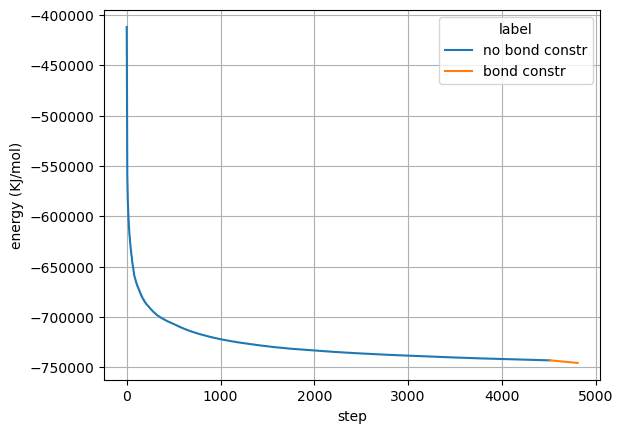

In [12]:
%%script true
ax = sns.lineplot(x="Time (ps)", y="Potential",
        hue="label",
        data=ener_pd)
ax.set_xlabel('step')
ax.set_ylabel('energy (KJ/mol)')
plt.grid()

In [13]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.em_' + datetime.date.today().strftime("%Y%m%d") + ".pycpt"
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

## From here, run in cluster
### System minimisation and equilibration

Based on `gromacs_py` docs, this is a 3-stage equilibriation process. 

All three steps seem to be NPT with berendsen coupling and v-rescale for temp coupling. Each step just has different restraints. This does not seem so bad: closer to lab conditions.

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/).

**Note:** 
1. Had to run this on cluster at least. Too slow even in ofc workstn.
2. Temperature coupling groups have to be set properly. See [mdtutorials](http://www.mdtutorials.com/gmx/complex/06_equil.html) and [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#System-equilibration)
3. Ligand name is `PYC` as seen in the index file by visual inspection.

In [ ]:
#%%script true
import pickle, datetime
chkpt_fname='checkpoint.em_20250221.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [ ]:
#%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '12'))
sys_name = "ku04amp01_pgl_complex"
#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.equi_three_step(out_folder=equi_folder,
        name=sys_name,
        nsteps_HA=HA_step,  
        nsteps_CA=CA_step,
        nsteps_CA_LOW=CA_LOW_step,
        dt=dt, dt_HA=dt_HA,
        tc_grps='Protein_GL1 Water_and_ions',
        tau_t= '0.1 0.1',
        ref_t= '310 310',
        vsite=vsite, maxwarn=10, iter_num=1)

In [6]:
#%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_' + datetime.date.today().strftime("%Y%m%d") + ".pycpt"
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

### Plot Equilibriation

Since the statistical ensemble is pretty much always NPT, this is different from the Lemkul-lysozyme tutorial at [MDTutorials](http://www.mdtutorials.com/gmx/lysozyme/). So we need to see Volume as well as Pressure, temperature, and density.

In [4]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_20250204.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [ ]:
%%script true
quantities = ["Temperature", "Pressure", "Volume", "Density"]
units = ["$K$", "$bar$", "$A^3$", "$kg/m^3$"]

pd_1 = complex_sys.sys_history[-2].get_ener(selection_list=quantities)
pd_2 = complex_sys.sys_history[-1].get_ener(selection_list=quantities)
pd_3 = complex_sys.get_ener(selection_list=quantities)

pd_1['label'] = 'HA_constr'
pd_2['label'] = 'CA_constr'
pd_2['Time (ps)'] = pd_2['Time (ps)'] + pd_1['Time (ps)'].max()
pd_3['label'] = 'CA_LOW_constr'
pd_3['Time (ps)'] = pd_3['Time (ps)'] + pd_2['Time (ps)'].max()

display(pd.concat([pd_1, pd_2, pd_3]))

In [ ]:
%%script true
plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(4, 1, figsize=(24,13.5), sharex=True, tight_layout=True)

for ax, quantity, unit in zip(axs, quantities, units):
    for df in (pd_1, pd_2, pd_3):
        ax.plot(df["Time (ps)"], df[quantity], label=str(df['label'][0]))
        ax.set_ylabel(quantity + "(" + unit + ")")
        ax.grid()

axs[0].legend()
axs[-1].set_xlabel("Time (ps)");

Looks okay to me. Fluctuations are high at the end because CA constraints are low, but there is a well-defined average.

### Plot RMSD

In [ ]:
%%script true
# Define reference structure for RMSD calculation
ref_sys =  complex_sys.sys_history[1]
struct="Protein"

rmsd_pd_1 = complex_sys.sys_history[-2].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_2 = complex_sys.sys_history[-1].get_rmsd([struct, struct], ref_sys=ref_sys)
rmsd_pd_3 = complex_sys.get_rmsd([struct, struct], ref_sys=ref_sys)


rmsd_pd_1['label'] = 'HA_constr'
rmsd_pd_2['label'] = 'CA_constr'
rmsd_pd_2['time'] = rmsd_pd_2['time'] + rmsd_pd_1['time'].max()
rmsd_pd_3['label'] = 'CA_LOW_constr'
rmsd_pd_3['time'] = rmsd_pd_3['time'] + rmsd_pd_2['time'].max()

display(pd.concat([rmsd_pd_1, rmsd_pd_2, rmsd_pd_3]))


In [ ]:
%%script true
fig, ax = plt.subplots(1, 1, figsize=(24,13.5))

for df in (rmsd_pd_1, rmsd_pd_2, rmsd_pd_3):
        ax.plot(df["time"], df["Protein"], label=str(df['label'][0]))
        
ax.set_title(struct)
ax.set_ylabel('RMSD (nm)')
ax.set_xlabel('Time (ps)')
plt.grid()

## Production MD 

tc-coupling groups are required here as well. See [gromacs-py manual](https://gromacs-py.readthedocs.io/en/latest/notebook/01_dna_ligand_ambertools.html#Production)

In [6]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.equi_20250204.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

In [8]:
%%script true
#Parallelization
nthreads = int(os.environ.get('PBS_NCPUS', '16'))

#Set Parallelization
complex_sys.nt = nthreads
#complex_sys.ntmpi = 1
complex_sys.gpu_id = '0'

complex_sys.production(out_folder=prod_folder,
        nsteps=prod_step,
        tc_grps='Protein_GL1 Water_and_ions',
        tau_t= '0.1 0.1',
        ref_t= '310 310',
        dt=dt, vsite=vsite, maxwarn=1, nstlist=200)

## Checkpointing for extending


In [ ]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.prod_' + datetime.date.today().strftime("%Y%m%d") + '.pycpt'
with open(chkpt_fname, 'wb') as py_cpt:
    pickle.dump(complex_sys, py_cpt)

## Post-Production

In [12]:
%%script true
import pickle, datetime
chkpt_fname='checkpoint.prod_20250128.pycpt'

with open(chkpt_fname, 'rb') as py_cpt:
    complex_sys = pickle.load(py_cpt)

### Prepare Production Trajectory for Viewing

#### Center Trajectory

In [ ]:
%%script true
# Center trajectory
complex_sys.center_mol_box(traj=True)

## Final Steps
As in any simulation conducted with periodic boundary conditions, molecules may appear "broken" or may "jump" back and forth across the box. To recenter the protein and rewrap the molecules within the unit cell to recover the desired box shape, invoke trjconv. 

Choose "Protein" for centering and "System" for output.

In [ ]:
%%script true
complex_sys.convert_trj(select='Protein\nSystem', fit='rot+trans', pbc='none')

#### Extract production initial condition
Optionally, extract the first frame of the final prod traj (latest from history, as the running one got updated) into a `pdb` for loading into post processing.

In [ ]:
%%script true
complex_sys.sys_history[-1].convert_trj(select='Protein\nSystem', fit='rot+trans', pbc='none', specific_coor_out=prod_folder+"/start.pdb", dump="0")